# Visualize Firm Nodes Edges

Visualize network of company mentions

This notebook aggregates mentions at the firm level

In [77]:
# Packages
import pandas as pd
import os
# Network stuff
import networkx as nx
from pyvis.network import Network
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import colorcet as cc

## Load Data

In [78]:
# Load '../../../Data/Company_Mentions/Company_Mentions_With_Ticker.xlsx'
company_mentions_with_ticker = pd.read_excel('../../../Data/Company_Mentions/Company_Mentions_With_Ticker.xlsx')
company_mentions_with_ticker

,ticker,fixed_quarter_date,company_mentioned,count,matched_ticker,Corporation_clean
0,LPX,2016-04-01,MOODY'S,1,MCO,MOODY'S
1,LYV,2015-07-01,APPLE,1,AAPL,APPLE
2,LYV,2016-01-01,APPLE,1,AAPL,APPLE
3,LYV,2016-04-01,APPLE,1,AAPL,APPLE
4,LYV,2016-07-01,CISCO,3,CSCO,CISCO
...,...,...,...,...,...,...
3330,HOV,2015-10-01,MERITAGE HOMES,1,MTH,MERITAGE HOMES
3331,HOV,2015-10-01,CONSOLIDATED,1,CNSL,CONSOLIDATED
3332,KODK,2015-10-01,AMAZON,1,AMZN,AMAZON
3333,KODK,2016-04-01,ENTERPRISE,1,EPD,ENTERPRISE


## Get pairwise tickers

In [79]:
pairwise_df = (company_mentions_with_ticker[['ticker', 'matched_ticker']].rename(columns={'ticker': 'ticker1', 'matched_ticker': 'ticker2'})
                                                                         .value_counts()
                                                                         .reset_index()
                                                                         .rename(columns={0: 'count'}))

pairwise_df

,ticker1,ticker2,count
0,RS,MSCI,26
1,OTEX,ORCL,26
2,EQIX,MSFT,24
3,OTEX,MSFT,24
4,MDLZ,SBUX,22
...,...,...,...
1288,MMM,DHR,1
1289,MMM,HON,1
1290,MMP,EPD,1
1291,MMP,HEP,1


In [80]:
# Order doesn't matter!

# Iterate over rows, create sorted list of tickers
pairwise_df['sorted_tickers'] = pairwise_df[['ticker1', 'ticker2']].apply(lambda x: sorted(x), axis=1)

# Sort the rows by the sorted_tickers column
pairwise_df = pairwise_df.sort_values('sorted_tickers')

# Duplicates on sorted_tickers
#print(pairwise_df[pairwise_df.duplicated('sorted_tickers')])

# Split sorted tickers into two columns again
pairwise_df[['ticker1', 'ticker2']] = pd.DataFrame(pairwise_df['sorted_tickers'].tolist(), index=pairwise_df.index)

# Print duplicates on ticker1 and ticker2
#print(pairwise_df[pairwise_df.duplicated(['ticker1', 'ticker2'])])

# Collapse to sums of count by ticker1 and ticker2
pairwise_df = pairwise_df.groupby(['ticker1', 'ticker2']).agg({'count': 'sum'}).reset_index()

pairwise_df

,ticker1,ticker2,count
0,AAPL,ACIW,1
1,AAPL,ADP,1
2,AAPL,ADSK,2
3,AAPL,ALGT,2
4,AAPL,ALK,1
...,...,...,...
1223,TGT,WWW,2
1224,TMUS,USM,4
1225,TMUS,VMI,2
1226,TOL,VGR,1


## Add Company Name and Sector

In [81]:
# Load rating datasets for company name

# Dataset 1
rating_data_1 = pd.read_csv(os.path.expanduser('~/Box/STAT 222 Capstone/Raw Data/Supplementary Credit Rating Data From Kaggle/corporateCreditRatingWithFinancialRatios.csv'))
print(rating_data_1.columns)
# Keep Ticker and Corporation, rename Ticker to ticker, Corporation to company
rating_data_1 = rating_data_1[['Ticker', 'Corporation']].rename(columns={'Ticker': 'ticker', 'Corporation': 'company'})
# Drop duplicates
rating_data_1.drop_duplicates(inplace=True)

# Dataset 2
rating_data_2 = pd.read_csv(os.path.expanduser('~/Box/STAT 222 Capstone/Raw Data/Credit Rating Data From Kaggle/corporate_rating.csv'))
print(rating_data_2.columns)
# Keep Symbol and Name, rename Symbol to ticker, Name to company
rating_data_2 = rating_data_2[['Symbol', 'Name']].rename(columns={'Symbol': 'ticker', 'Name': 'company'})
# Drop duplicates
rating_data_2.drop_duplicates(inplace=True)

# Stack the two datasets and take a random item for each duplicate on ticker
rating_data_names = pd.concat([rating_data_1, rating_data_2], axis=0)
rating_data_names.drop_duplicates(subset='ticker', keep='first', inplace=True)
rating_data_names


Index(['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK',
       'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')
Index(['Rating', 'Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector',
       'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFl

,ticker,company
0,AWR,American States Water Co.
1,ADP,Automatic Data Processing Inc.
2,AVT,Avnet Inc.
3,CWT,California Water Service Co.
4,CAH,Cardinal Health Inc.
...,...,...
2019,IRS,IRSA Inversiones Y Representaciones S.A.
2020,IT,"Gartner, Inc."
2022,XPER,Xperi Holding Corporation
2023,IMO,Imperial Oil Limited


In [82]:
# Need to reload all data, just ticker and sector columns
# list of files in '../../../Data/All_Data/All_Data_Fixed_Quarter_Dates'
file_list = [f for f in os.listdir(r'../../../Data/All_Data/All_Data_Fixed_Quarter_Dates') if f.endswith('.parquet')]
# read in all parquet files
sector_df = pd.concat([pd.read_parquet(r'../../../Data/All_Data/All_Data_Fixed_Quarter_Dates/' + f, columns=['ticker', 'Sector']) for f in file_list]).drop_duplicates()
sector_df

,ticker,Sector
0,AAPL,Information Technology
10,ABB,Industrials
14,ABBV,Health Care
23,ABC,Health Care
46,ABG,Consumer Discretionary
...,...,...
772,XRAY,Health Care
794,XYL,Industrials
795,YUM,Consumer Discretionary
815,ZBRA,Information Technology


In [83]:
# Inner join rating_data_names and sector_df on ticker
rating_data_names_sector = rating_data_names.merge(sector_df, on='ticker', how='inner')
rating_data_names_sector

,ticker,company,Sector
0,AWR,American States Water Co.,Utilities
1,ADP,Automatic Data Processing Inc.,Information Technology
2,AVT,Avnet Inc.,Information Technology
3,CWT,California Water Service Co.,Utilities
4,CAH,Cardinal Health Inc.,Health Care
...,...,...,...
494,RFP,Resolute Forest Products Inc.,Materials
495,ALKS,Alkermes plc,Health Care
496,EA,Electronic Arts Inc.,Communication Services
497,MX,MagnaChip Semiconductor Corporation,Information Technology


In [84]:
# Left join on ticker1
pairwise_df = pairwise_df.merge(rating_data_names_sector, left_on='ticker1', right_on='ticker', how='left')
pairwise_df.drop(columns='ticker', inplace=True)
pairwise_df.rename(columns={'company': 'company1', 'Sector': 'Sector1'}, inplace=True)
# Left join on ticker2
pairwise_df = pairwise_df.merge(rating_data_names_sector, left_on='ticker2', right_on='ticker', how='left')
pairwise_df.drop(columns='ticker', inplace=True)
pairwise_df.rename(columns={'company': 'company2', 'Sector': 'Sector2'}, inplace=True)
# Put variable names containing 1 first, then 2, then count
pairwise_df = pairwise_df[['ticker1', 'company1', 'Sector1', 'ticker2', 'company2', 'Sector2', 'count']]
# Number of companies
print('number companies')
print(len(set(list(pairwise_df['ticker1'].unique()) + list(pairwise_df['ticker2'].unique()))))
pairwise_df

number companies
387


,ticker1,company1,Sector1,ticker2,company2,Sector2,count
0,AAPL,Apple Inc.,Information Technology,ACIW,ACI Worldwide Inc.,Information Technology,1
1,AAPL,Apple Inc.,Information Technology,ADP,Automatic Data Processing Inc.,Information Technology,1
2,AAPL,Apple Inc.,Information Technology,ADSK,"Autodesk, Inc.",Information Technology,2
3,AAPL,Apple Inc.,Information Technology,ALGT,Allegiant Travel Company,Industrials,2
4,AAPL,Apple Inc.,Information Technology,ALK,Alaska Air Group Inc.,Industrials,1
...,...,...,...,...,...,...,...
1223,TGT,Target Corp.,Consumer Discretionary,WWW,Wolverine World Wide Inc,Consumer Discretionary,2
1224,TMUS,T-Mobile US Inc.,Communication Services,USM,United States Cellular Corporation,Communication Services,4
1225,TMUS,T-Mobile US Inc.,Communication Services,VMI,Valmont Industries Inc.,Industrials,2
1226,TOL,Toll Brothers Inc.,Consumer Discretionary,VGR,Vector Ltd.,Consumer Staples,1


In [85]:
# For each company, get list of connected companies
order_one = pairwise_df[['company1', 'company2', 'count']]
order_two = pairwise_df[['company2', 'company1', 'count']].rename(columns={'company2': 'company1', 'company1': 'company2'})
# stack and sum
edge_counts = pd.concat([order_one, order_two]).groupby(['company1', 'company2']).agg({'count': 'sum'}).reset_index()
# for each company1, keep five most connected companies
edge_counts = edge_counts.groupby('company1').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
# collapse into list of connected companies
list_of_connected_companies = edge_counts.groupby('company1').agg({'company2': list}).reset_index()
# rename company1 to company, company2 to connected_companies
list_of_connected_companies.rename(columns={'company1': 'company', 'company2': 'connected_companies'}, inplace=True)
# convert list to string
# if there are more than insertion_point items, insert a newline after the third item
insertion_point = 2
def list_to_string(lst):
    if len(lst) > insertion_point:
        return ', '.join(lst[:insertion_point]) + ',\n' + ', '.join(lst[insertion_point:])
    else:
        return ', '.join(lst)
list_of_connected_companies['connected_companies'] = list_of_connected_companies['connected_companies'].apply(list_to_string)
print(list_of_connected_companies)
print(list_of_connected_companies['connected_companies'][3])

                      company  \
0                  3M Company   
1                   AAR CORP.   
2          ACI Worldwide Inc.   
3                       AECOM   
4            AGCO Corporation   
..                        ...   
381          Xcel Energy Inc.   
382          Yum! Brands Inc.   
383  Zebra Technologies Corp.   
384               Zoetis Inc.   
385                 eBay Inc.   

                                   connected_companies  
0    Post Holdings, Inc., Danaher Corp.,\nHoneywell...  
1    Union Pacific Corporation, Trinity Industries ...  
2    Fiserv Inc., Cisco Systems, Inc.,\nTarget Corp...  
3    Trimble Inc., Alliant Energy Corp.,\nAutodesk,...  
4    Caterpillar Inc., Titan International, Inc.,\n...  
..                                                 ...  
381  Otter Tail Corporation, PTC Inc.,\nBlack Hills...  
382  Starbucks Corp., Hyatt Hotels Corporation,\nOr...  
383  Motorola Solutions Inc., Microsoft Corp.,\nEnt...  
384    Abbott Laboratories, Merck

## Plotting

In [86]:
# Keep company1, company2, cosine_similarity
nw_cols = pairwise_df[['company1', 'company2', 'ticker1', 'ticker2', 'count']]
# Rename to 'Source', 'Target', 'Weight'
nw_cols.rename(columns={'company1': 'Source', 'company2': 'Target', 'count': 'weight'}, inplace=True)
# Where missing, fill company1 with ticker1 and company2 with ticker2
nw_cols['Source'].fillna(nw_cols['ticker1'], inplace=True)
nw_cols['Target'].fillna(nw_cols['ticker2'], inplace=True)
# Add column 'Type' with value 'Undirected'
nw_cols['Type'] = 'Undirected'
# Limit to just node cols
#nw_cols = nw_cols[['Source', 'Target']]
print(nw_cols)

                     Source                              Target ticker1  \
0                Apple Inc.                  ACI Worldwide Inc.    AAPL   
1                Apple Inc.      Automatic Data Processing Inc.    AAPL   
2                Apple Inc.                      Autodesk, Inc.    AAPL   
3                Apple Inc.            Allegiant Travel Company    AAPL   
4                Apple Inc.               Alaska Air Group Inc.    AAPL   
...                     ...                                 ...     ...   
1223           Target Corp.            Wolverine World Wide Inc     TGT   
1224       T-Mobile US Inc.  United States Cellular Corporation    TMUS   
1225       T-Mobile US Inc.             Valmont Industries Inc.    TMUS   
1226     Toll Brothers Inc.                         Vector Ltd.     TOL   
1227  WEC Energy Group Inc.                    Xcel Energy Inc.     WEC   

     ticker2  weight        Type  
0       ACIW       1  Undirected  
1        ADP       1  Undirec

C:\Users\ijyli\AppData\Local\Temp\ipykernel_28552\2372261029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_cols.rename(columns={'company1': 'Source', 'company2': 'Target', 'count': 'weight'}, inplace=True)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_28552\2372261029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw_cols['Source'].fillna(nw_cols['ticker1'], inplace=True)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_28552\2372261029.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [87]:
# Load as graph
G = nx.from_pandas_edgelist(nw_cols, 
                            source='Source', 
                            target='Target', 
                            edge_attr='weight'
                            )

In [88]:
# Add coloring for sectors
# Get list of sectors
sectors = list(set(list(pairwise_df['Sector1'].unique()) + list(pairwise_df['Sector2'].unique())))
# Order the list
sectors.sort()

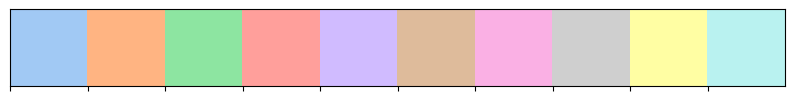

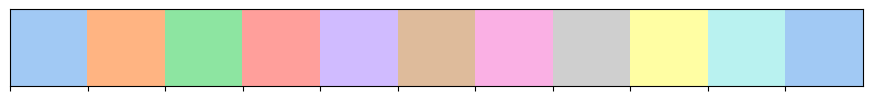

In [89]:
# visualize seaborn Pastel1 colors
#sns.palplot(sns.color_palette("Pastel1"))
# visualize seaborn Pastel2 colors
#sns.palplot(sns.color_palette("Pastel2"))
# visualize seaborn Pastel colors
sns.palplot(sns.color_palette("pastel"))
# visualize more seaborn colors
#sns.palplot(sns.color_palette("deep"))
# test palette
sns.palplot(sns.color_palette("pastel", len(sectors)))

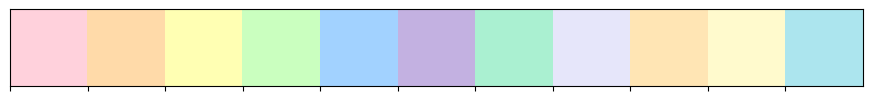

In [90]:
# # Create a color palette
# color_palette = sns.color_palette("pastel", len(sectors) - 1).as_hex()
# # add on first item for 'Accent'
# color_palette.insert(len(color_palette), sns.color_palette("Accent", 1).as_hex()[0])
#color_palette = sns.color_palette("Set3", len(sectors)).as_hex()
#color_palette = sns.color_palette("tab20", len(sectors)).as_hex()
color_palette = ["#FFD1DC", "#FFDAA9", "#FFFFB3", "#CAFFBF", "#A2D2FF", "#C3B1E1", "#AAF0D1", "#E6E6FA", "#FFE5B4", "#FFFACD", "#ACE5EE"]
#color_palette = sns.color_palette(cc.glasbey, n_colors=len(sectors)).as_hex()
# visualize color_palette
sns.palplot(color_palette)

In [91]:
# drop grey which is the eighth color
#color_palette.pop(7)
# drop second to last color
#color_palette.pop(-2)
print(color_palette)
color_palette = {sectors[i]: color_palette[i] for i in range(len(sectors))}

['#FFD1DC', '#FFDAA9', '#FFFFB3', '#CAFFBF', '#A2D2FF', '#C3B1E1', '#AAF0D1', '#E6E6FA', '#FFE5B4', '#FFFACD', '#ACE5EE']


In [92]:
# Nodes dataframe, based on pairwise_df
pw_company1 = pairwise_df[['company1', 'Sector1']].rename(columns={'company1': 'id', 'Sector1': 'Sector'})
pw_company2 = pairwise_df[['company2', 'Sector2']].rename(columns={'company2': 'id', 'Sector2': 'Sector'})
# Stack and deduplicate
nodes_df = pd.concat([pw_company1, pw_company2]).drop_duplicates()

# Add node attributes for colors from nodes_df
for node in G.nodes():
    # Find the group from nodes_df
    #print(node)
    group = nodes_df[nodes_df['id'] == node]['Sector'].values[0]
    #print(group)
    # Set the color attribute
    nx.set_node_attributes(G, {node: {'color': color_palette[group]}})
    # Set the Sector attribute
    nx.set_node_attributes(G, {node: {'Sector': group}})
    # Set the connected companies attribute
    connected_companies = list_of_connected_companies[list_of_connected_companies['company'] == node]['connected_companies'].values[0]
    nx.set_node_attributes(G, {node: {'connected_companies': connected_companies}})

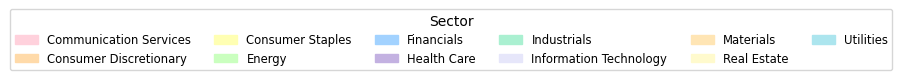

In [93]:
# Produce legend/color key
# Create patches for the legend
patches = [mpatches.Patch(color=color, label=label) for label, color in color_palette.items()]

# Plot legend
plt.figure(figsize=(8, 0.25))
plt.legend(handles=patches, ncol=6, loc='center', fontsize='small', title='Sector')
plt.axis('off')
plt.savefig('../../../Output/Company Mentions Network/legend.png', bbox_inches='tight', dpi=600)
plt.show()

In [94]:
# Pyvis network
pvn = Network(notebook=True)
pvn.from_nx(G)
#pvn.toggle_physics(True) # turn off movement
# add physics controls
#pvn.show_buttons(filter_=['physics'])

# Make tooltips
for node, node_attrs in G.nodes(data=True):
    tooltip_text = f"Company: {node}\n" \
                   f"Sector: {node_attrs.get('Sector', 'No description available.')}\n" \
                   f"Most Connected Companies: {node_attrs.get('connected_companies', 'No description available.')}"
    pvn.get_node(node)['title'] = tooltip_text

# use repulsion
pvn.repulsion(node_distance=400)

# turn off physics
#pvn.toggle_physics(False)

# # speed rendering
# for node in pvn.get_nodes():
#   pvn.get_node(node)['physics']=False
#   pvn.get_node(node)['label']=str(node)
# pvn.toggle_physics(False)

# for node in pvn.get_nodes():
#   pvn.get_node(node)['x']=pvn[node][0]
#   pvn.get_node(node)['y']=-pvn[node][1] #the minus is needed here to respect networkx y-axis convention 
#   pvn.get_node(node)['physics']=False
#   pvn.get_node(node)['label']=str(node) #set the node label as a string so that it can be displayed
# pvn.toggle_physics(False)

pvn.show('../../../Output/Company Mentions Network/Firm_Company_Mentions_Network.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Version Sampling 50% of Nodes

In [95]:
# Get all values of ticker across ticker1 and ticker2
all_tickers = list(set(list(pairwise_df['ticker1'].unique()) + list(pairwise_df['ticker2'].unique())))
# Set seed
import random
random.seed(222)
# Sample 50% of tickers
sample_tickers = random.sample(all_tickers, int(0.5 * len(all_tickers)))


In [96]:
# Create nw_cols_sample as items with ticker1 and ticker2 in sample_tickers
nw_cols_sample = nw_cols[(nw_cols['ticker1'].isin(sample_tickers)) & (nw_cols['ticker2'].isin(sample_tickers))]
nw_cols_sample

,Source,Target,ticker1,ticker2,weight,Type
86,ACI Worldwide Inc.,"Cisco Systems, Inc.",ACIW,CSCO,4,Undirected
87,ACI Worldwide Inc.,Fiserv Inc.,ACIW,FISV,6,Undirected
89,ACI Worldwide Inc.,NetApp Inc.,ACIW,NTAP,1,Undirected
90,ACI Worldwide Inc.,OGE Energy Corp.,ACIW,OGE,1,Undirected
114,Automatic Data Processing Inc.,Amazon.com Inc.,ADP,AMZN,1,Undirected
...,...,...,...,...,...,...
1205,Starbucks Corp.,Tupperware Brands Corporation,SBUX,TUP,6,Undirected
1206,Starbucks Corp.,Visteon Corporation,SBUX,VC,2,Undirected
1207,Starbucks Corp.,Yum! Brands Inc.,SBUX,YUM,8,Undirected
1216,Sunoco LP,"SunCoke Energy, Inc.",SUN,SXC,1,Undirected


In [97]:
# For each company, get list of connected companies
# rename source to company1, target to company2, weight to count
nw_c_renamed = nw_cols_sample.rename(columns={'Source': 'company1', 'Target': 'company2', 'weight': 'count'})
# For each company, get list of connected companies
order_one = nw_c_renamed[['company1', 'company2', 'count']]
order_two = nw_c_renamed[['company2', 'company1', 'count']].rename(columns={'company2': 'company1', 'company1': 'company2'})
# stack and sum
edge_counts = pd.concat([order_one, order_two]).groupby(['company1', 'company2']).agg({'count': 'sum'}).reset_index()
# for each company1, keep five most connected companies
edge_counts = edge_counts.groupby('company1').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
# collapse into list of connected companies
list_of_connected_companies = edge_counts.groupby('company1').agg({'company2': list}).reset_index()
# rename company1 to company, company2 to connected_companies
list_of_connected_companies.rename(columns={'company1': 'company', 'company2': 'connected_companies'}, inplace=True)
# convert list to string
# if there are more than insertion_point items, insert a newline after the third item
insertion_point = 2
def list_to_string(lst):
    if len(lst) > insertion_point:
        return ', '.join(lst[:insertion_point]) + ',\n' + ', '.join(lst[insertion_point:])
    else:
        return ', '.join(lst)
list_of_connected_companies['connected_companies'] = list_of_connected_companies['connected_companies'].apply(list_to_string)
print(list_of_connected_companies)
print(list_of_connected_companies['connected_companies'][3])

                             company  \
0                 ACI Worldwide Inc.   
1              ALBEMARLE CORPORATION   
2                  AMC Networks Inc.   
3    Air Products and Chemicals Inc.   
4              Alaska Air Group Inc.   
..                               ...   
164    Williams Companies Inc. (The)   
165              XPO Logistics, Inc.   
166                 Yum! Brands Inc.   
167         Zebra Technologies Corp.   
168                        eBay Inc.   

                                   connected_companies  
0    Fiserv Inc., Cisco Systems, Inc.,\nNetApp Inc....  
1             Chevron Corporation, Halliburton Company  
2    EPR Properties, Amazon.com Inc.,\nMondelez Int...  
3                       Marathon Petroleum Corporation  
4       Starbucks Corp., Amazon.com Inc.,\nGoogle Inc.  
..                                                 ...  
164  Cabot Corp., Chevron Corporation,\nHess Corpor...  
165                      PepsiCo Inc., Amazon.com Inc.  
166  S

In [98]:
# Load as graph
G_sample = nx.from_pandas_edgelist(nw_cols_sample, 
                            source='Source', 
                            target='Target', 
                            edge_attr='weight'
                            )

In [99]:
# # Add node attributes for colors from nodes_df
# for node in G_sample.nodes():
#     # Find the group from nodes_df
#     #print(node)
#     group = nodes_df[nodes_df['id'] == node]['Sector'].values[0]
#     #print(group)
#     #print(color_palette[group])
#     #print(group)
#     #color = sns.utils.rgb2hex(color_palette[group])
#     # Set the color attribute
#     nx.set_node_attributes(G_sample, {node: {'color': color}})

# Add node attributes for colors from nodes_df
for node in G_sample.nodes():
    # Find the group from nodes_df
    #print(node)
    group = nodes_df[nodes_df['id'] == node]['Sector'].values[0]
    #print(group)
    # Set the color attribute
    nx.set_node_attributes(G_sample, {node: {'color': color_palette[group]}})
    # Set the Sector attribute
    nx.set_node_attributes(G_sample, {node: {'Sector': group}})
    # Set the connected companies attribute
    connected_companies = list_of_connected_companies[list_of_connected_companies['company'] == node]['connected_companies'].values[0]
    nx.set_node_attributes(G_sample, {node: {'connected_companies': connected_companies}})

In [100]:
# Pyvis network
pvn = Network(notebook=True)
pvn.from_nx(G_sample)

# Make tooltips
for node, node_attrs in G_sample.nodes(data=True):
    tooltip_text = f"Company: {node}\n" \
                   f"Sector: {node_attrs.get('Sector', 'No description available.')}\n" \
                   f"Most Connected Companies: {node_attrs.get('connected_companies', 'No description available.')}"
    pvn.get_node(node)['title'] = tooltip_text


#pvn.toggle_physics(True) # turn off movement
# add physics controls
#pvn.show_buttons(filter_=['physics'])
#pvn.show_buttons(filter_=False)
# use repulsion
pvn.repulsion(node_distance=250)
pvn.show('../../../Output/Company Mentions Network/Firm_Company_Mentions_Network_50_Percent_Node_Sample.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Pre-Computing

In [101]:
# Compute the layout
pos = nx.spring_layout(G)  # You can change this to any other layout

# Convert positions to format suitable for Pyvis
#pyvis_pos = {node: {"x": int(pos[node][0]*1000), "y": int(pos[node][1]*1000)} for node in G.nodes}

# Create a Pyvis network
net = Network(notebook=True)

# net.add_nodes(G.nodes, value=[1]*len(G.nodes), title=str(G.nodes), x=[pyvis_pos[n]['x'] for n in G.nodes], y=[pyvis_pos[n]['y'] for n in G.nodes])
# net.add_edges(G.edges)

# Add nodes with positions computed from NetworkX
for node, (x, y) in pos.items():
    net.add_node(node, x=int(x*1000), y=int(y*1000))

# Add edges
for edge in G.edges():
    net.add_edge(edge[0], edge[1])

# Make tooltips
for node, node_attrs in G.nodes(data=True):
    tooltip_text = f"Company: {node}\n" \
                   f"Sector: {node_attrs.get('Sector', 'No description available.')}"
    net.get_node(node)['title'] = tooltip_text

# Add node attributes for colors from nodes_df
for node in G.nodes():
    # Find the group from nodes_df
    #print(node)
    group = nodes_df[nodes_df['id'] == node]['Sector'].values[0]
    #print(group)
    # Set the color attribute
    #net.set_node_attributes(G, {node: {'color': color_palette[group]}})
    net.get_node(node)['color'] = color_palette[group]
    # Set the Sector attribute
    #net.set_node_attributes(G, {node: {'Sector': group}})
    net.get_node(node)['Sector'] = group

#pvn.toggle_physics(True) # turn off movement
# add physics controls
#pvn.show_buttons(filter_=['physics'])
#pvn.show_buttons(filter_=False)
# use repulsion
net.repulsion(node_distance=250)
net.show('../../../Output/Company Mentions Network/Firm_Company_Mentions_Network_Precomputed.html')

# Show the network
#net.show("karate_club.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
